In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from data_preprocessing import preprocess_data
from data_preprocessing import remove_correlated_variables
from data_preprocessing import cap_outliers
from data_loading import load_data
from approval_matrix import plot_approval_matrix
from models import cross_val_pr_curve,tune_hyperparameters

In [2]:
train_data_path="/Users/heba/Desktop/Erdos/Training Dataset A_R-384891_Candidate Attach #1_PresSE_SRF #1142.csv"
test_data_path="/Users/heba/Desktop/Erdos/Evaluation Dataset B_R-384891_Candidate Attach #2_PresSE_SRF #1142.csv"
train_df, test_df = load_data(train_data_path,test_data_path)
X_train_processed, y_train, X_test_processed, y_test=preprocess_data(train_df, test_df)

/Users/heba/Desktop/data-science-spring-2025/project/NEW/data_preprocessing.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28. 17. 26. ... 73. 33. 56.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = df[col].clip(upper=upper_limit)


In [3]:
# Initialize individual classifiers

best_params_rf={'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2\
                , 'n_estimators': 300}
best_params_xgb={'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, \
                 'scale_pos_weight': 0.3544383149448345, 'subsample': 0.7}

rf_clf_ensemble = RandomForestClassifier(**best_params_rf)

xgb_clf_ensemble = xgb.XGBClassifier(**best_params_xgb)

# Create an ensemble using VotingClassifier
ensemble_clf = VotingClassifier(
    estimators=[('rf', rf_clf_ensemble), ('xgb', xgb_clf_ensemble)], 
    voting='soft'  # 'hard' for majority vote; 'soft' uses probabilities
)

# Fit the ensemble model on training data
ensemble_clf.fit(X_train_processed, y_train)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=20,
                                                     n_estimators=300)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

Cross-Validation Precision Scores: [0.93962025 0.94095037 0.9397689 ]
Mean Precision Score: 0.940113172073915
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      5654
           1       0.88      0.92      0.90     15952

    accuracy                           0.85     21606
   macro avg       0.81      0.79      0.80     21606
weighted avg       0.84      0.85      0.85     21606



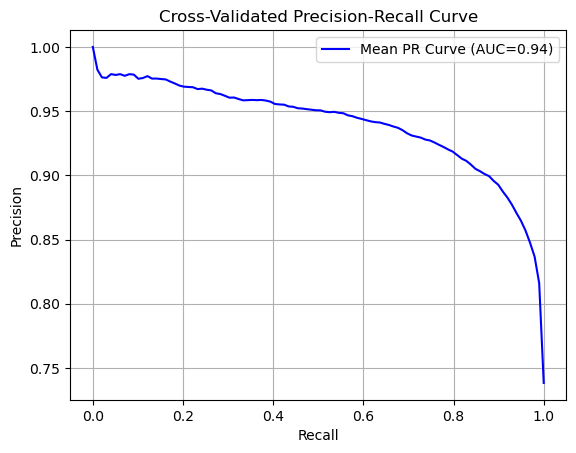

Mean Precision-Recall AUC: 0.9406


In [4]:
from models import evaluate_models
evaluate_models(ensemble_clf, X_train_processed, y_train,'average_precision')

**Feature Importance Using Permuatiuon**


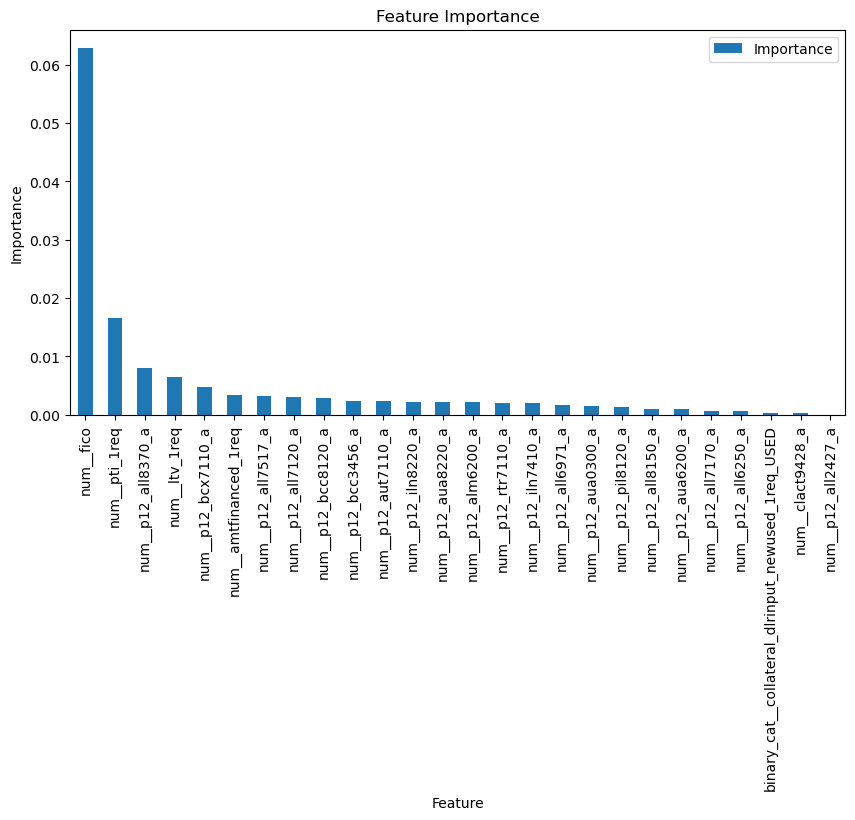

In [5]:
from models import feature_importance
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
feature_importance(ensemble_clf, X_train_processed, y_train,'average_precision')

In [6]:
y_pred_ensemble_test = ensemble_clf.predict(X_test_processed)

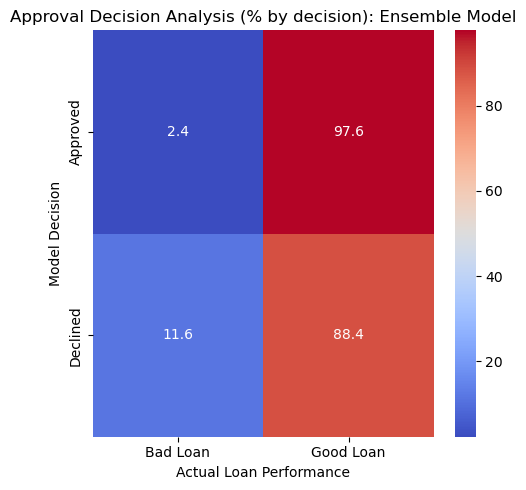

In [7]:
plot_approval_matrix(y_pred_ensemble_test,pd.read_csv(test_data_path)['bad_flag'], 'Ensemble Model')

In [9]:
print("Ensemble model approval rate: ", y_pred_ensemble_test.mean())

Ensemble model approval rate:  0.76


In [10]:
gender_aprv = pd.DataFrame({'Gender': pd.read_csv(test_data_path)['Gender'], 'Model_Aprv': y_pred_ensemble_test, 'True_Aprv': pd.read_csv(test_data_path)['aprv_flag']})
gender_aprv.groupby(['Gender']).mean()

,Model_Aprv,True_Aprv
Gender,,
Female,0.762346,0.737654
Male,0.763314,0.749739
Undefined,0.702703,0.683398


In [11]:
race_aprv = pd.DataFrame({'Race': pd.read_csv(test_data_path)['Race'], 'Model_Aprv': y_pred_ensemble_test, 'True_Aprv': pd.read_csv(test_data_path)['aprv_flag']})
race_aprv.groupby(['Race']).mean()

,Model_Aprv,True_Aprv
Race,,
Asian,0.791367,0.755396
Black,0.756164,0.724658
Hispanic,0.730832,0.721044
Other,0.729223,0.718499
White,0.775580,0.756480
